In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
import ObsModels
import fun

from FSC import GenerationContinuousObs as FSC_ContinuousObs
from FSC import InferenceContinuousObs as FSC_InferenceContinuousObs

import numba as nb
import pandas as pd

In [3]:
path = "../data/data_filtered"
df = pd.read_csv(path)

In [4]:
cell_indexes = np.unique(df["particle"])
cell_indexes.size

3485

In [86]:
actions = []
frames = []
observations = []


MinTrLen = 300
MaxTrLen = 800
InitSkip = 10

np.random.seed(0)

for cell_idx in cell_indexes:
    cell = df[df["particle"] == cell_idx]
    cact = cell["tumbling"].values[InitSkip:]
    cfra = cell["frame"].values[InitSkip:]
    cobs = cell["c_norm"].values[InitSkip:]

    # check if a trajectory is shorter than MaxTrLen, otherwise break it into pieces
    if len(cact) < MaxTrLen and len(cact) > MinTrLen:
        actions.append(cact)
        frames.append(cfra)
        observations.append(cobs)
    else:
        NewTrLen = np.random.randint(MinTrLen, MaxTrLen)
        for i in range(0, len(cact), NewTrLen):
            new_traj = cact[i:i+NewTrLen]
            if len(new_traj) < NewTrLen:
                continue
            actions.append(cact[i:i+NewTrLen])
            frames.append(cfra[i:i+NewTrLen])
            observations.append(cobs[i:i+NewTrLen])

NTraj = len(actions)

actions = actions[:NTraj]
frames = frames[:NTraj]
observations = observations[:NTraj]

In [87]:
trajectories = []

for i in range(NTraj):
    dict_traj = {}
    dict_traj["actions"] = actions[i].astype(int)
    dict_traj["features"] = np.array([np.ones(observations[i].size).astype(np.float32), observations[i].astype(np.float32)])

    trajectories.append(dict_traj)

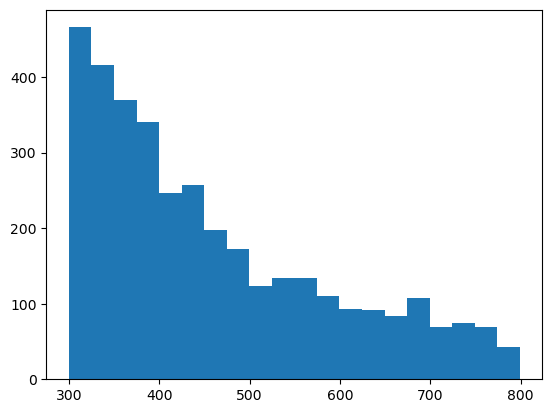

In [88]:
plt.hist([len(tr["actions"]) for tr in trajectories], bins=20)
plt.show()

In [92]:
first_action = np.array([tr["actions"][0] for tr in trajectories])

print("Number of trajectories: ", len(trajectories))
print("Number of tumbling at the beginning: ", np.sum(first_action))
print("Fraction of tumbling at the beginning: ", np.round(np.sum(first_action) / len(trajectories) * 100, 2), "%")

Number of trajectories:  3600
Number of tumbling at the beginning:  79
Fraction of tumbling at the beginning:  2.19 %


In [9]:
seeds = [5, 6, 7, 8, 9, 10]
F = 2
M = 2
A = 2


for seed in seeds:
    FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = seed)
    FSC_tofit.load_trajectories(trajectories)

    tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 50, lr = 0.05, gamma = 0.99, train_split = 0.9)

    par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_seed_{seed}_NTrajs{len(trajectories)}_MinTrLen{MinTrLen}_MaxTrLen{MaxTrLen}_InitSkip{InitSkip}_"

    np.save(par_names + "theta.npy", FSC_tofit.theta.detach().cpu().double().numpy())
    np.save(par_names + "psi.npy", FSC_tofit.psi.detach().cpu().double().numpy())
    np.save(par_names + "tloss.npy", np.array(tloss))
    np.save(par_names + "vloss.npy", np.array(vloss))

Training with 800 trajectories and validating with 200 trajectories.
Epoch 1 - Training loss: 385.009296875, Validation loss: 214.04319396972656 - Learning rate: 0.05
Epoch 2 - Training loss: 140.5913720703125, Validation loss: 98.70318689346314 - Learning rate: 0.0495
Epoch 3 - Training loss: 80.3655419921875, Validation loss: 72.1125943183899 - Learning rate: 0.049005
Epoch 4 - Training loss: 65.15609588623047, Validation loss: 64.78077554702759 - Learning rate: 0.04851495
Epoch 5 - Training loss: 60.54302215576172, Validation loss: 61.95319858551025 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 58.54395477294921, Validation loss: 60.640728635787966 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 57.56973327636718, Validation loss: 59.92908181190491 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 57.02360656738282, Validation loss: 59.52670099258423 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 56.70900054931641, Validation loss: 59.2937086

KeyboardInterrupt: 

In [8]:

FSC_tofit = FSC_InferenceContinuousObs(M, A, F, seed = 123456)
FSC_tofit.load_trajectories(trajectories)

In [9]:
%%time
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 50, lr = 0.05, gamma = 0.99)

Training with 800 trajectories and validating with 200 trajectories.
Epoch 1 - Training loss: 194.8594024658203, Validation loss: 111.26819829940796 - Learning rate: 0.05
Epoch 2 - Training loss: 81.63197052001952, Validation loss: 68.36888070106507 - Learning rate: 0.0495
Epoch 3 - Training loss: 61.20737701416016, Validation loss: 61.056689720153805 - Learning rate: 0.049005
Epoch 4 - Training loss: 57.49599578857422, Validation loss: 59.53608479499817 - Learning rate: 0.04851495
Epoch 5 - Training loss: 56.610234680175786, Validation loss: 59.15315393447876 - Learning rate: 0.0480298005
Epoch 6 - Training loss: 56.382813415527345, Validation loss: 59.02433392524719 - Learning rate: 0.047549502495
Epoch 7 - Training loss: 56.291186828613284, Validation loss: 58.984590482711795 - Learning rate: 0.04707400747005
Epoch 8 - Training loss: 56.2604019165039, Validation loss: 58.97108362197876 - Learning rate: 0.0466032673953495
Epoch 9 - Training loss: 56.248111877441396, Validation loss: 

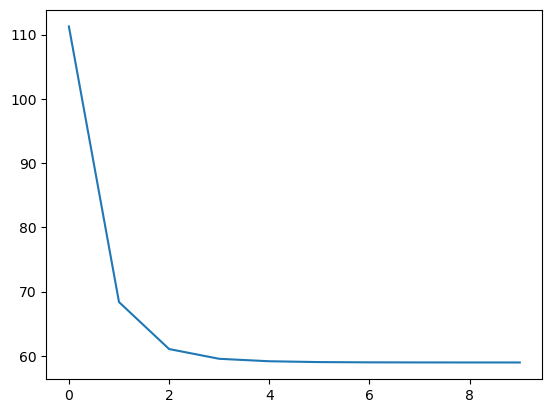

In [10]:
plt.plot(vloss)

In [11]:
testnum = 2
par_names = f"../data/parameters/FSC_tofit_M{M}_A{A}_F{F}_test_{testnum}_"

np.save(par_names + "theta.npy", FSC_tofit.theta.detach().cpu().double().numpy())
np.save(par_names + "psi.npy", FSC_tofit.psi.detach().cpu().double().numpy())

In [64]:
FSC_inferred = FSC_ContinuousObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                                 FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 features.


In [65]:
FSC_inferred.load_features([trajectories[0]["features"]])

In [66]:
NSteps = 1500
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)
Time = np.arange(NSteps)

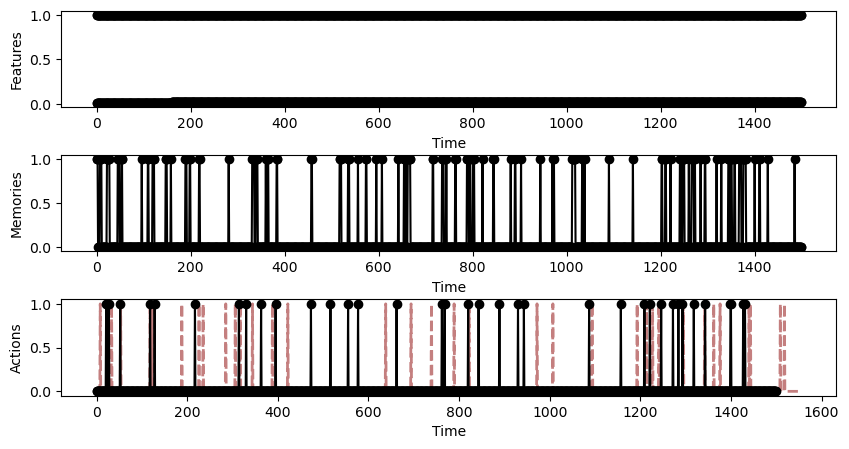

In [67]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

ax[2].plot(trajectories[idx_trj]["actions"], label = "True", color = "darkred", zorder = -1, alpha = 0.5, lw = 2, ls = "--")

[1.         0.04071564]


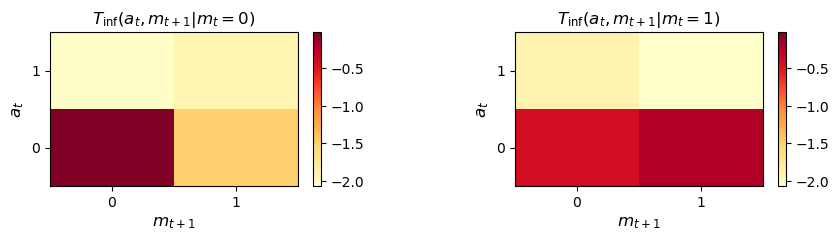

[1.         0.06264174]


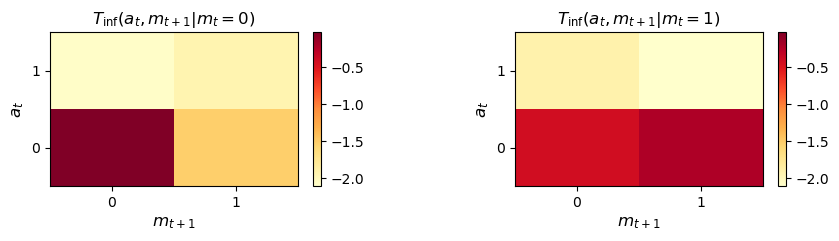

[1.         0.01300097]


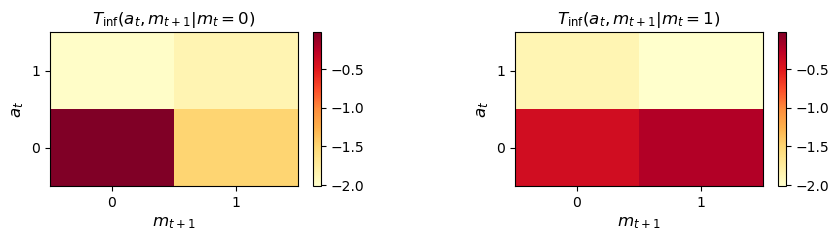

[1.         0.01332454]


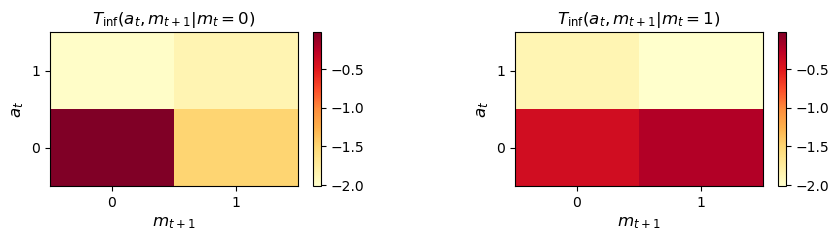

[1.         0.01005741]


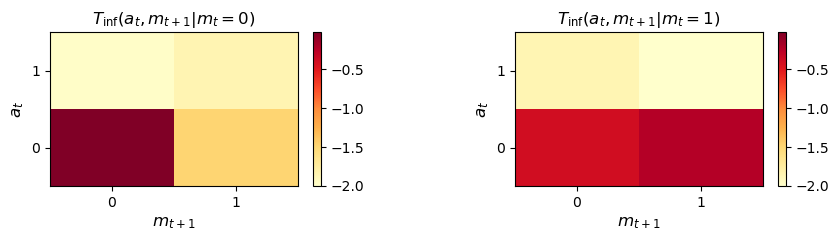

In [68]:
Nfeat_toplot = 5

np.random.seed(0)
idxs_f = np.random.choice(len(trajectories), Nfeat_toplot, replace = False)
t = 20
for idx_f in idxs_f:
    fig, axs = plt.subplots(1, M, figsize=(10,2))
    plt.subplots_adjust(hspace = 0.9, wspace=0.5)
    for a in axs.flatten():
        a.set_xticks(range(M))
        a.set_yticks(range(A))
        a.set_xlabel("$m_{t+1}$", fontsize = 12)
        a.set_ylabel("$a_t$", fontsize = 12)

    feature_test = trajectories[idx_f]["features"][:, t]
    print(feature_test)

    TMat_inf = FSC_inferred.get_TMat(feature_test)

    vmin = TMat_inf.min()
    vmax = TMat_inf.max()

    for idx_m, m in enumerate(range(M)):
        im_inf = axs[idx_m].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, np.log10(TMat_inf[idx_m].T),
                                       vmin = np.log10(vmin), vmax = np.log10(vmax), cmap = "YlOrRd")

        axs[idx_m].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[idx_m])


    plt.show()

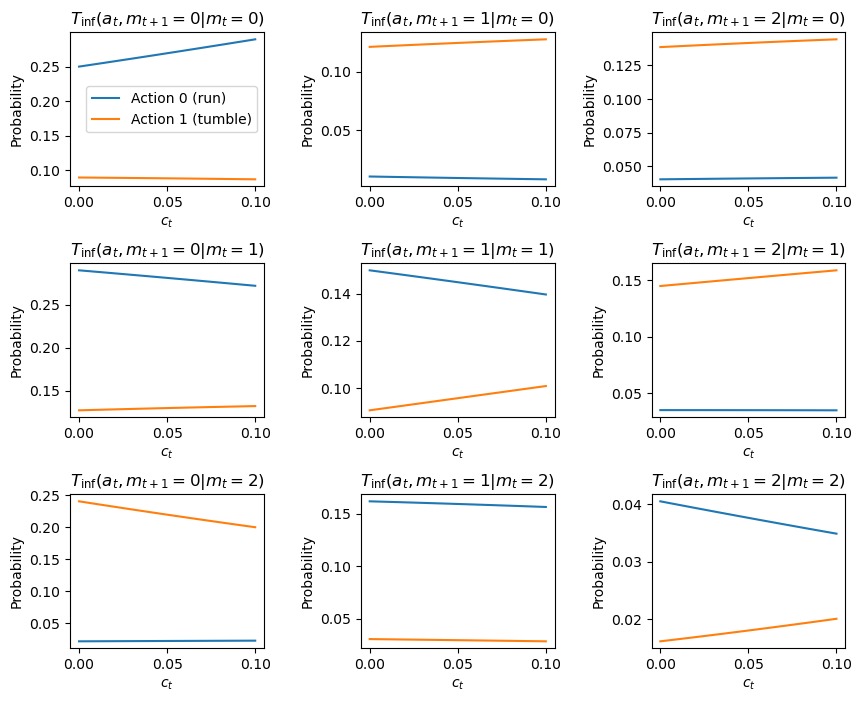

In [54]:
c_array = np.linspace(0, 0.1, 100)
feature_array = np.array([np.ones(c_array.size), c_array])

TMat_array = FSC_inferred.get_TMat(feature_array)

fig, ax = plt.subplots(M, M, figsize=(10,8))
plt.subplots_adjust(hspace = 0.5, wspace=0.5)

for idx_m, m in enumerate(range(M)):
    for idx_m2, m2 in enumerate(range(M)):
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 0], label = f"Action 0 (run)")
        ax[idx_m, idx_m2].plot(c_array, TMat_array[:, idx_m, idx_m2, 1], label = f"Action 1 (tumble)")

        ax[idx_m, idx_m2].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} = {m2} | m_t = {m})$")
        ax[idx_m, idx_m2].set_xlabel("$c_t$")
        ax[idx_m, idx_m2].set_ylabel("Probability")

ax[0, 0].legend()

plt.show()